t-distributed stochastic neighbor embedding (t-SNE)

딥러닝을 적용한 예전 논문들을 보면 feature를 2차원으로 차원축소하여 class간의 구분이 잘 되었는지 보기 위해 t-SNE를 사용하기도 함

t-SNE를 이용하면 훈련경과에 따른 모델의 성능이 feature들이 구분되는 것을 시각화할 수 있음

해석 시 유의할 점
- t-SNE에서 point간의 거리는 어떤 의미도 가지지 않음


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from torch import nn
from torch.nn import functional as F

In [2]:
gpu_idx = 3

if torch.cuda.is_available() and type(gpu_idx) == int:
    device = torch.device("cuda:{}".format(gpu_idx))
    current_device = torch.cuda.current_device()
    print("Device: {} ({})\n".format(torch.cuda.get_device_name(current_device), device))
else:
    device = torch.device('cpu')
    print("Device: CPU\n")

Device: GeForce RTX 2080 Ti (cuda:3)



# 1. Load data

In [3]:
import pickle, cv2

def gen_label(data, cls):
#     label = cls*np.ones([data.shape[0]])
    label = cls*np.ones([len(data)])
    return label

def Image_norm(img, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
    """
    img: np.array (h, w, ch) or (n, h, w, ch) ~ [0, 255] integer
    mean and std vaules were used for normalizing input data to ImageNet models in torch 
    """
    return (img/255-mean)/std

def reshape4torch(img, norm = False):
    """
    (sample #, height, width, channel) -> (sample #, channel, height, width)
    """
    if norm == True:
        img = Image_norm(img)
        
    if len(img.shape) == 4:
        img = np.transpose(img, (0, 3, 1, 2))
        return img
    elif len(img.shape) == 3:
        img = np.transpose(img, (2, 0, 1))
        return np.expand_dims(img, axis=0)

def load_image_from_path(path_list, normalization = False, extract_name = False):
    data = []
    for i in path_list:
        temp = cv2.imread(i)

        data.append(temp)
    if extract_name != False:
        name = []
        for i in path_list:
            name.append(os.path.basename(i))
        return reshape4torch(np.asarray(data), norm = normalization), np.asarray(name)
    else:
        return reshape4torch(np.asarray(data), norm = normalization)

def test_data_load(filename):
    
    root = '/mnt/disk2/data/private_data/SMhospital/capsule/1 preprocessed'
    data_dir = root + '/database'
    
    with open(root + '/' + filename, "rb") as f:
        data_config = pickle.load(f)

    test_files = data_config['test_files']

    test_names, test_Xs, test_Ys = [], [], []
    for i, test_file in enumerate(test_files):
        test_path = [os.path.join(data_dir, f) for f in test_file]
        print(len(test_path))
        test_Ys.append(gen_label(test_path, int(i)))

        imgs, filenames = load_image_from_path(test_path, extract_name = True)
        test_Xs.append(imgs)
        test_names.append(filenames)
        
    test_name = np.concatenate(test_names)
    test_X = np.concatenate(test_Xs)
    test_Y = np.concatenate(test_Ys)
    
    return test_name, test_X, test_Y

In [4]:
test_name, test_X, test_Y = test_data_load('data_config_np-hd_frb_sv.pkl')

test_X.shape, test_Y.shape

1005
1362


((2367, 3, 512, 512), (2367,))

# 2. Load model

In [5]:
class CNN_v1(nn.Module):
    def __init__(self, n_ch, n_cls):
        super().__init__()

        self.conv1_1 = nn.Conv2d(n_ch, 16, 3, 1, padding=1)
        self.conv1_2 = nn.Conv2d(16, 16, 3, 1, padding=1)
        self.maxp1 = nn.MaxPool2d(2, 2)
        
        self.conv2_1 = nn.Conv2d(16, 16, 3, 1, padding=1)
        self.conv2_2 = nn.Conv2d(16, 16, 3, 1, padding=1)
        self.maxp2 = nn.MaxPool2d(2, 2)
        
        self.conv3_1 = nn.Conv2d(16, 16, 3, 1, padding=1)
        self.conv3_2 = nn.Conv2d(16, 16, 3, 1, padding=1)
        self.maxp3 = nn.MaxPool2d(2, 2)
        
        self.conv4_1 = nn.Conv2d(16, 32, 3, 1, padding=1)
        self.conv4_2 = nn.Conv2d(32, 32, 3, 1, padding=1)
        self.maxp4 = nn.MaxPool2d(2, 2)

        self.conv5_1 = nn.Conv2d(32, 32, 3, 1, padding=1)
        self.conv5_2 = nn.Conv2d(32, 32, 3, 1, padding=1)
        self.maxp5 = nn.MaxPool2d(2, 2)
        
        self.conv6_1 = nn.Conv2d(32, 32, 3, 1, padding=1)
        self.conv6_2 = nn.Conv2d(32, 32, 3, 1, padding=1)
        self.maxp6 = nn.MaxPool2d(2, 2)
        
        self.conv7_1 = nn.Conv2d(32, 64, 3, 1, padding=1)
        self.conv7_2 = nn.Conv2d(64, 64, 3, 1, padding=1)
        self.maxp7 = nn.MaxPool2d(2, 2)
        
        self.dense1 = nn.Linear(4*4*64, 100)
        self.dropout1 = nn.Dropout(0.3)
        self.dense2 = nn.Linear(100, 50)
        self.dropout2 = nn.Dropout(0.3)
        self.dense3 = nn.Linear(50, n_cls)
        
    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = self.maxp1(x)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = self.maxp2(x)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = self.maxp3(x)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = self.maxp4(x)
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = self.maxp5(x)
        x = F.relu(self.conv6_1(x))
        x = F.relu(self.conv6_2(x))
        x = self.maxp6(x)
        x = F.relu(self.conv7_1(x))
        x = F.relu(self.conv7_2(x))
        x = self.maxp7(x)
        # flatten
        x = x.view(-1, 4*4*64)
        feature = F.relu(self.dense1(x))
        x = self.dropout1(feature)
        x = F.relu(self.dense2(x))
        x = self.dropout2(x)
        x = self.dense3(x)
        x = F.softmax(x, dim = -1)
        return x

In [6]:
model_dir = './model/'
model_name = 'np-hd_---_--'

def find_models(model_dir, model_name):
    model_list = [i for i in sorted(os.listdir(model_dir)) if model_name in i]
#     model_list = sorted(glob.glob('nh/model/{}*'.format(model_name)))
    return model_list

model_list = find_models(model_dir, model_name)
model_list

n_ch = 3
n_cls = 2

network = CNN_v1(n_ch, n_cls)
        
model = network
model = model.to(device)

model_file = model_list[-1]

model.load_state_dict(torch.load(model_dir + model_file, map_location=lambda storage, loc: storage.cuda(gpu_idx)))
model.eval()

CNN_v1(
  (conv1_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxp2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxp3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4_1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4_2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxp4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5_1): Conv

# 3. Feature extraction

In [7]:
def batch_idxs(dataset, batch_size = 32, shuffle = False):

    idxs = np.arange(len(dataset))
    total_size = len(idxs)
    if shuffle:
        np.random.shuffle(idxs)
    start = 0
    b_idxs = []
    while True:
        if total_size > start + batch_size: 
            b_idxs.append(list(idxs[start:start+batch_size]))  
            start += batch_size
        elif total_size <= start + batch_size: 
            b_idxs.append(list(idxs[start:]))
            break 
    return b_idxs

def feature_extraction(model, x, module_name = 'dense2'):
    features = []
    def hook_feature(module, input, output):
        features.append(output.data.cpu().numpy())

    model._modules.get(module_name).register_forward_hook(hook_feature)
    
    if len(x.shape) == 3:
        x = torch.tensor(x, device = device).float()
        logit = model((x.unsqueeze(0)).clone().detach().requires_grad_(True))
    else:
        b_idxs = batch_idxs(x, batch_size = 32, shuffle = False)
        for b_idx in b_idxs:
            xi = torch.tensor(x[b_idx], device = device).float()
            logit = model(xi.clone().detach().requires_grad_(True))
    return np.concatenate(features)

In [8]:
features= feature_extraction(model, test_X)

In [9]:
features.shape

(2367, 50)

# 4. t-SNE

In [10]:
from sklearn.manifold import TSNE

emb_x = TSNE(n_components=2, perplexity = 30).fit_transform(features)

In [11]:
emb_x.shape

(2367, 2)

In [12]:
def TSNE_plot(emb_x, y, class_name=['Normal', 'Abnormal'], class_idx = [0, 1], save_path = None):

    fig, ax = plt.subplots(1, 1, figsize= (15, 14))
    N_class = int(np.max(y))
    for n, i in enumerate(class_idx):
#     for i in range(N_class + 1):
        ax.plot(emb_x[np.where(y==i)[0], 0], emb_x[np.where(y==i)[0], 1], 
                '.',  ms= 8, alpha = 1,
                label = '{}'.format(class_name[n]))
    ax.legend(fontsize = 22, borderpad = 0.4, edgecolor = 'k')
    ax.set_xticks([]); ax.set_yticks([])
    ax.set_xlabel('$X1$', fontsize = 20); ax.set_ylabel('$X2$', fontsize = 20)
    # ax.spines['top'].set_visible(False)
    # ax.spines['right'].set_visible(False)
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.grid(color='r', linestyle='-', linewidth=2)
    fig.show()
    
    if not save_path == None:
        save_dir = '/'.join(save_path.split('/')[:-1])
        if not os.path.exists(save_dir): os.mkdir(save_dir)
        fig.savefig(save_path, bbox_inches='tight')

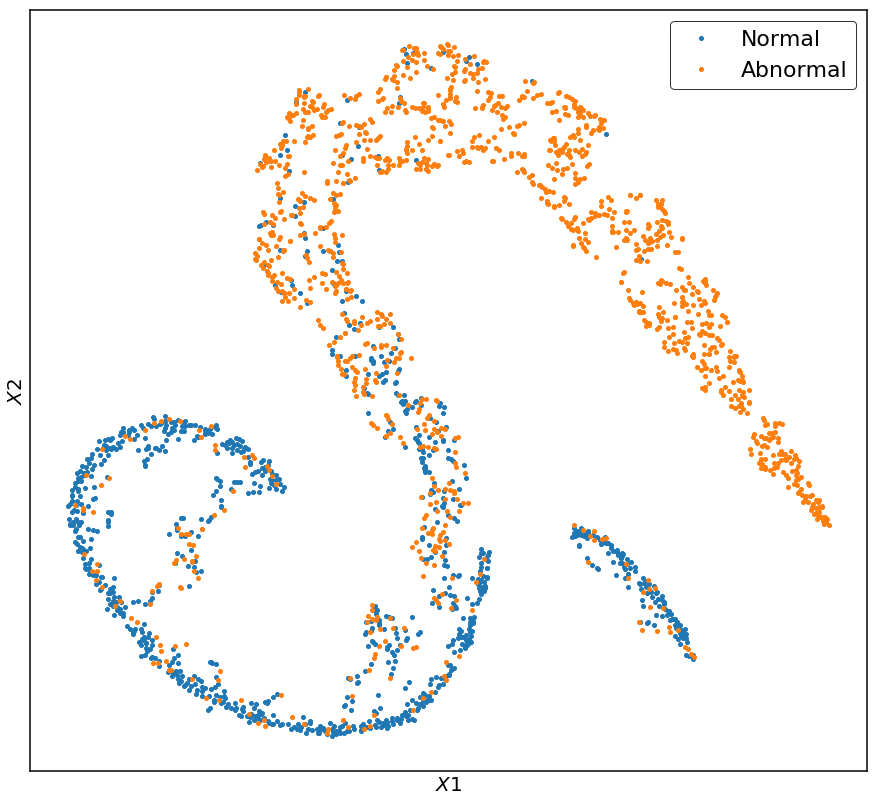

In [13]:
TSNE_plot(emb_x, test_Y, save_path = 'outputs/{}_t-SNE.png'.format(model_name))

이도 machine learning 기법으로 훈련할 때마다 결과가 달라짐

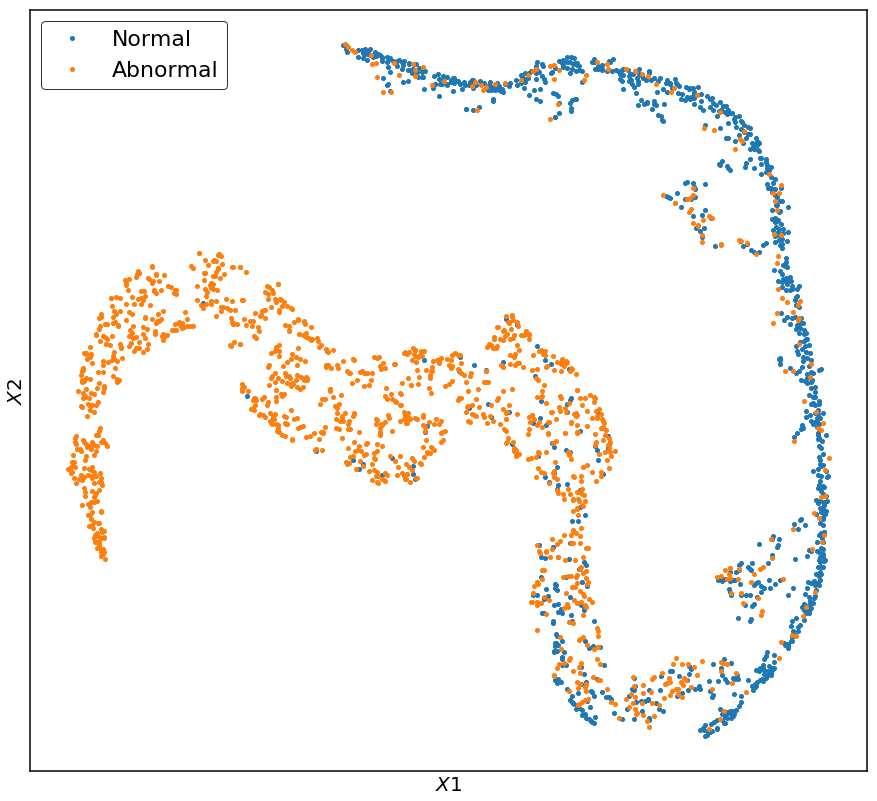

In [14]:
emb_x = TSNE(n_components=2, perplexity = 30).fit_transform(features)
TSNE_plot(emb_x, test_Y)

perplexity가 주요 parameter임
- 제공되는 함수에선 5-50 사이에서 조정하라고 권장하며 30이 default임
- 값이 커질수록 전체적인 모양이 압축되어 쭉 펴지는 느낌이 강함

- perplexity 10

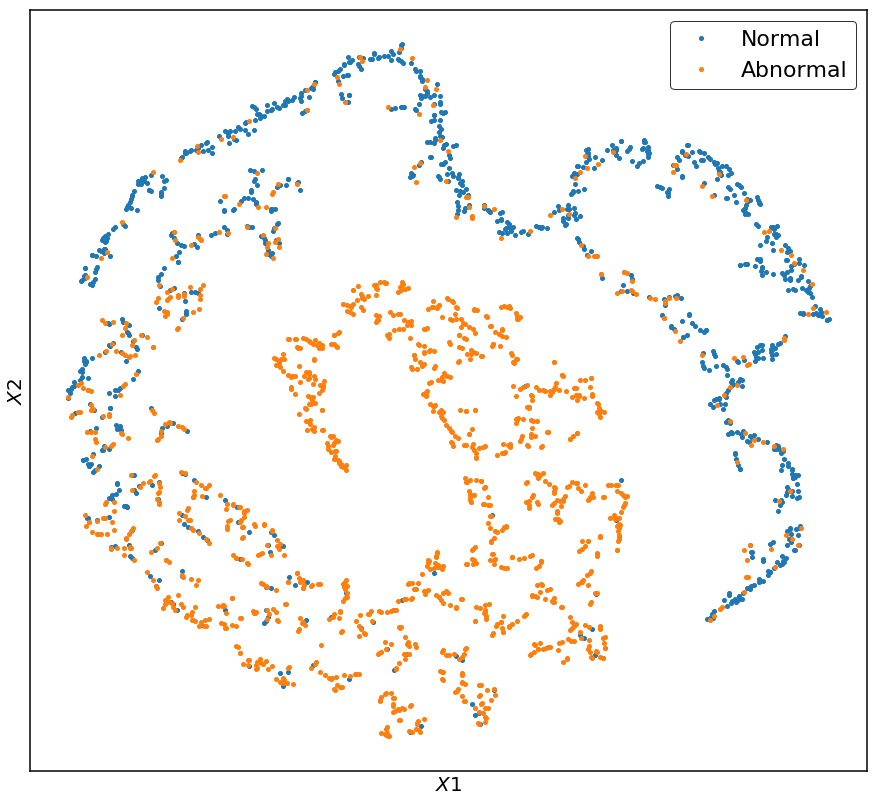

In [15]:
emb_x = TSNE(n_components=2, perplexity = 10).fit_transform(features)
TSNE_plot(emb_x, test_Y)

- perplexity 30 (default)

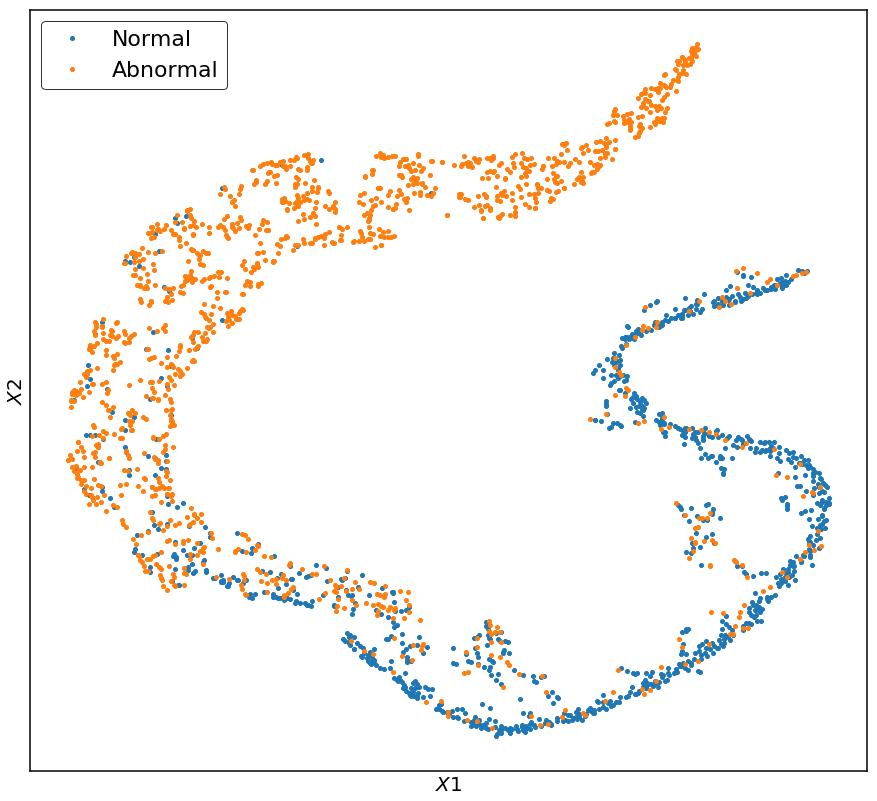

In [16]:
emb_x = TSNE(n_components=2, perplexity = 30).fit_transform(features)
TSNE_plot(emb_x, test_Y)

- perplexity 50

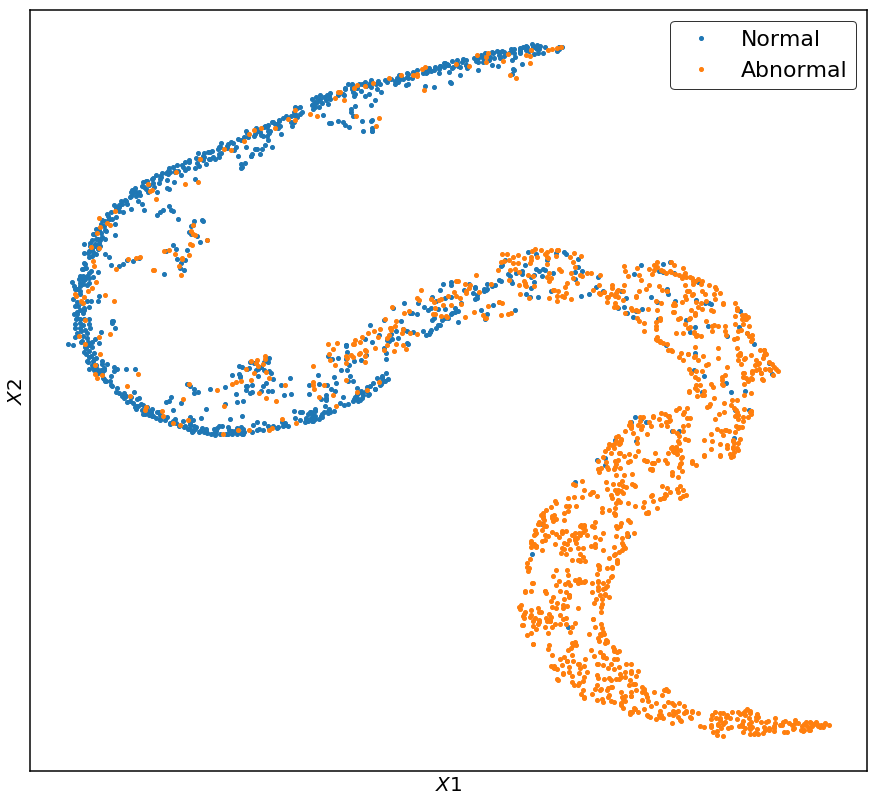

In [17]:
emb_x = TSNE(n_components=2, perplexity = 50).fit_transform(features)
TSNE_plot(emb_x, test_Y)

- perplexity 100

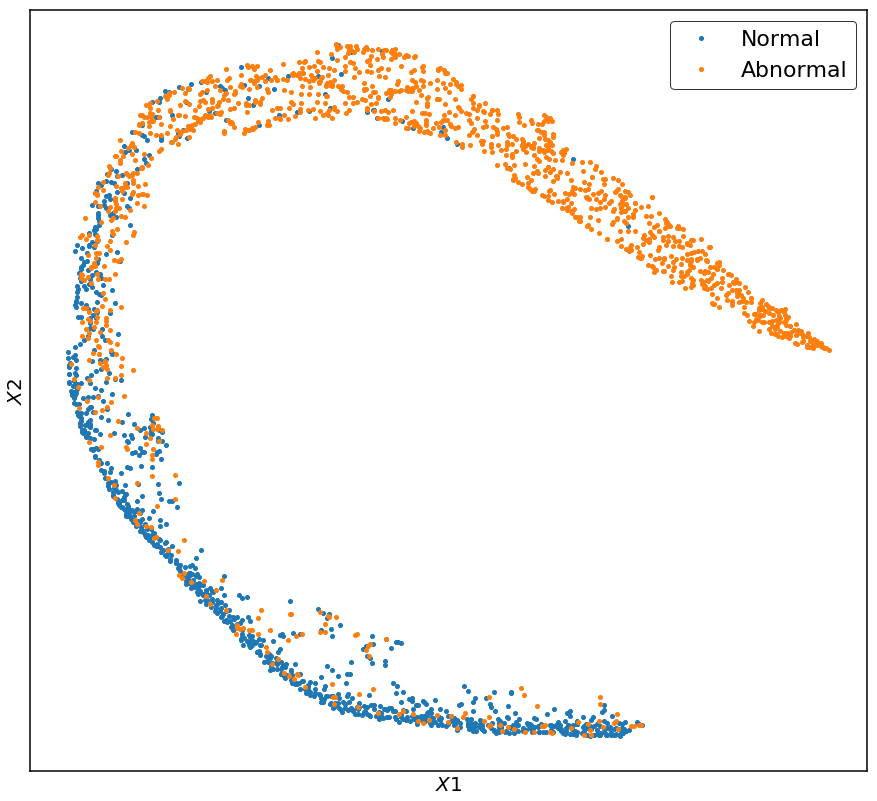

In [18]:
emb_x = TSNE(n_components=2, perplexity = 100).fit_transform(features)
TSNE_plot(emb_x, test_Y)

- perplexity 200

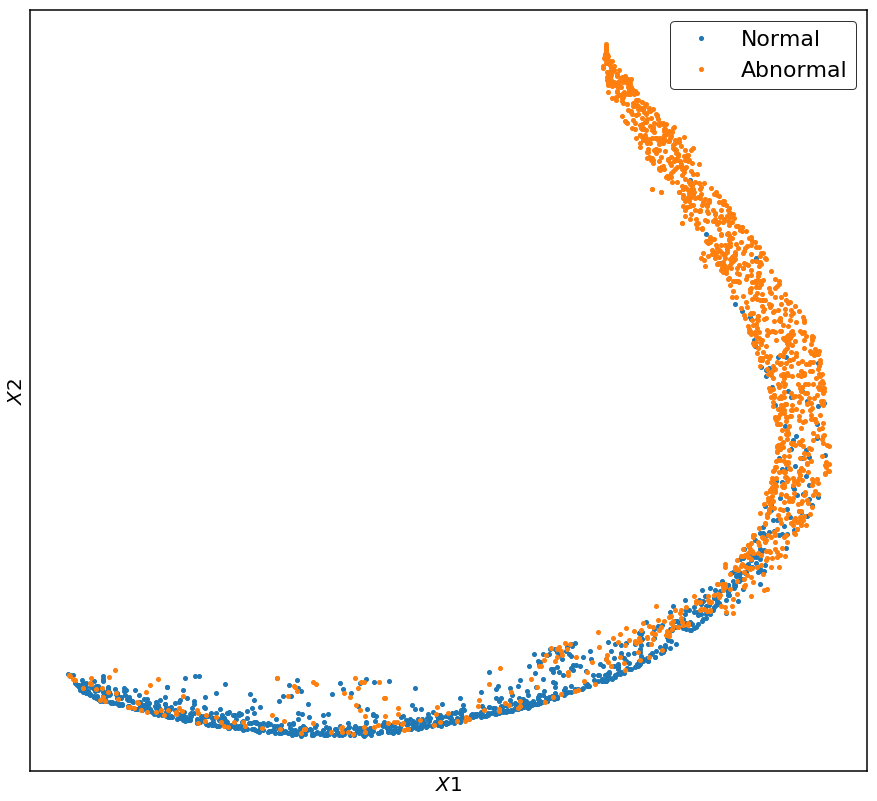

In [19]:
emb_x = TSNE(n_components=2, perplexity = 200).fit_transform(features)
TSNE_plot(emb_x, test_Y)

- perplexity 300

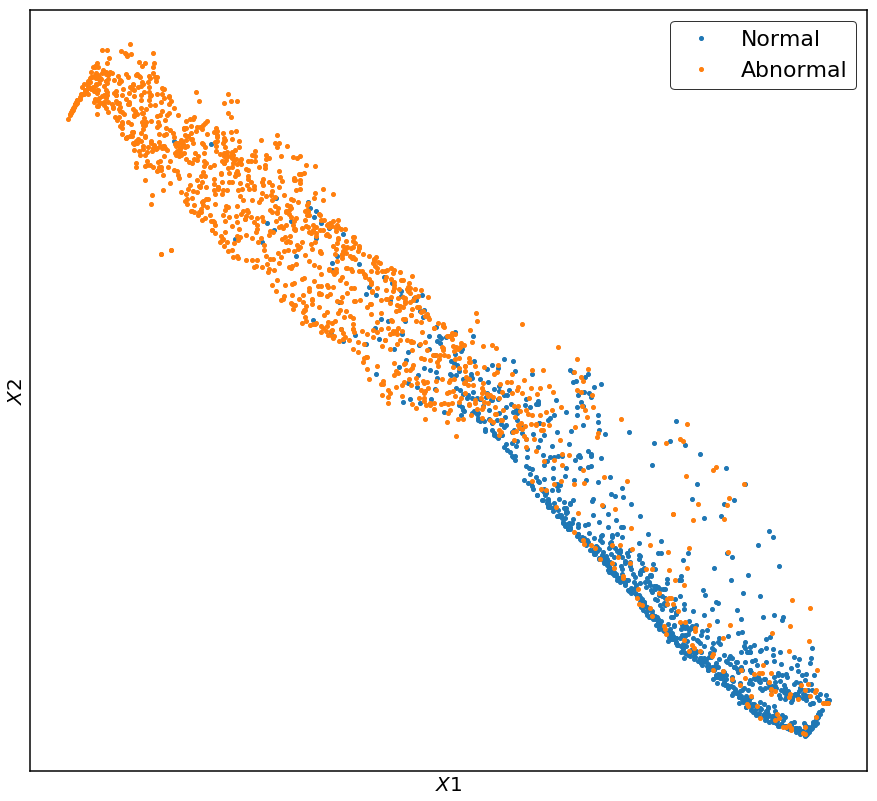

In [20]:
emb_x = TSNE(n_components=2, perplexity = 300).fit_transform(features)
TSNE_plot(emb_x, test_Y)